# CEO-Request Challenge

## 1. Problem statement (summarized)

>❓ How should Olist improve its profit margin ❓, given that it has 
> - some revenues per sellers per months
> - some revenues per orders
> - some reputation costs (estimated) per bad reviews
> - some operational costs of IT system that grows with number of orders, but not linearly (scale effects)


Let's recap our key findings so far :
- We have seen that `wait_time` was the most significant factor behind low review scores, but reading comments of the bad reviews also showed that some of them were linked to the seller or to the product itself.
- `wait_time` is made up of seller's `delay_to_carrier` + `carrier_delivery_time`. The latter being outside of Olist's direct control, improving it is not a quick-win recommendation we can make to Olist CEO without in-depth analysis of their operational practices.
- On the contrary, a better selection of `sellers` can positively impact the `delay_to_carrier` and reduce the number of bad `review_scores` on Olist.

👉 We recommend you to start with the the seller analysis 1.1) below, but feel free to investigate into other hypothesis instead 1.2)

### 1.1 (recommended) **Should Olist remove underperforming sellers from its marketplace ?** 🕵🏻

To analyse the impact of removing the worse sellers from Olist's marketplace, we will perform a what-if analysis: What would have happened if Olist had never accepted these sellers in the first place? (granted, it's hard to know in advance who is a good seller, but let's start with this and iterate later).

1️⃣ Compute, for each `seller_id`, and cumulated since the beginning:
- the `revenues` it brings
- the `costs` associated with all its bad reviews
- the resulting `profits` (revenues - costs)
- the number of `orders` (it will impact the overall IT costs)


2️⃣ We can then:
- sort sellers by increasing profits for Olist
- for each number of sellers to remove, compute the financial impact it would have made if they had never been accepted on the platform. 
- we may find an optimal number of sellers to remove that maximizes Olist's profit margin

👉 Write down a detailed strategy (step by step) to create the DataFrame you need for the first step.

<br>

<details>
    <summary> <i>💡 Think about how to re-use or update the logic you've already coded in your 🗂 `olist` package</i> </summary>


Starting from your current `seller().get_training_data()` DataFrame, can you easily transform it to compute:
- Olist's positive `revenue_per_seller`? 
- Olist's `cost_of_bad_reviews`?

You will orally present your insights to your favorite TA at the end of this unit `Communicate` "
</details>


### 1.2 (optional): Here are other hypothesis you may want to investigate instead

- Should Olist remove the worst performing products / categories from its marketplace entirely?
- Should Olist remove only consistently underperforming sellers, after it has a honeymoon period of few months?
- Should Olist restrict seller/customer pairs between certain states to avoid delays?
- Should Olist acquire new sellers, with some cost assumptions to be suggested?
- ...


## Your turn!

🧺 Keep this notebook tidy! 

📅 🗣 📊 You will orally present your insights to your favorite TA at the end of this unit `Communicate`

In [139]:
from olist.seller import Seller
import statsmodels.formula.api as smf
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## Unit Economics (detailed)

Revenue

    Olist takes a 10% cut on the product price (excl. freight) of each order delivered.
    Olist charges 80 BRL by month per seller.

Cost

In the long term, bad customer experience has business implications: low repeat rate, immediate customer support cost, refunds or unfavorable word of mouth communication. We will assume that we have an estimate measure of the monetary cost for each bad review:
    
    review_score: cost (BRL)
    1 star: 100
    2 stars: 50
    3 stars: 40
    4 stars: 0
    5 stars: 0

In addition, Olist’s IT costs (servers, etc…) increase with the amount of orders processed, albeit less and less rapidly (scale effects).

    For the sake of simplicity, we will consider Olist’s total cumulated IT Costs to be proportional to the square-root of the total cumulated number of orders approved.

The IT department also told you that since the birth of the marketplace, cumulated IT costs have amounted to 500,000 BRL.

### 1.1 (recommended) **Should Olist remove underperforming sellers from its marketplace ?** 🕵🏻

### Import data

In [60]:
sellers = Seller().get_training_data()
orders = Seller().order.get_training_data(with_distance_seller_customer=True)

### Calculate olist revenue, cost, & profit

In [61]:
# compute revenue each seller brings to Olist
sellers['olist_revenue'] = sellers['months_on_olist']*80 + sellers['sales']*.1

# compute cost each seller brings to Olist
order_items = Seller().data['order_items']
order_items = order_items.filter(['order_id', 'seller_id']).drop_duplicates()
orders_merged = orders.merge(order_items, on='order_id')
orders_merged['cost'] = orders_merged['review_score'].map({1: 100, 2: 50, 3: 40, 4: 0, 5: 0})
orders_merged['olist_cost'] = orders_merged.apply(lambda row: row['cost'] / row['number_of_sellers'], axis=1)
olist_cost = orders_merged.groupby('seller_id')[['olist_cost']].sum()
sellers_pl = sellers.merge(olist_cost, on='seller_id')

# compute profit each seller brings to Olist
sellers_pl['olist_profit'] = sellers_pl['olist_revenue'] - sellers_pl['olist_cost']

In [75]:
sellers_pl.head()

,seller_id,seller_city,seller_state,delay_to_carrier,wait_time,date_first_sale,date_last_sale,months_on_olist,n_orders,quantity,quantity_per_order,sales,share_of_five_stars,share_of_one_stars,review_score,olist_revenue,olist_cost,olist_profit
0,3442f8959a84dea7ee197c632cb2df15,campinas,SP,0.000000,13.018588,2017-05-05 16:25:11,2017-08-30 12:50:19,4.0,3,3,1.000,218.70,0.333333,0.333333,3.000000,341.870,120.0,221.870
1,d1b65fc7debc3361ea86b5f14c68d2e2,mogi guacu,SP,0.000000,9.065716,2017-03-29 02:10:34,2018-06-06 20:15:21,14.0,40,41,1.025,11703.07,0.731707,0.048780,4.560976,2290.307,140.0,2150.307
2,ce3ad9de960102d0677a81f5d0bb7b2d,rio de janeiro,RJ,0.000000,4.042292,2018-07-30 12:44:49,2018-07-30 12:44:49,0.0,1,1,1.000,158.00,1.000000,0.000000,5.000000,15.800,0.0,15.800
3,c0f3eea2e14555b6faeea3dd58c1b1c3,sao paulo,SP,0.000000,5.667187,2018-08-03 00:44:08,2018-08-03 00:44:08,0.0,1,1,1.000,79.99,1.000000,0.000000,5.000000,7.999,0.0,7.999
4,51a04a8a6bdcb23deccc82b0b80742cf,braganca paulista,SP,3.353727,35.314861,2017-11-14 12:15:25,2017-11-14 12:15:25,0.0,1,1,1.000,167.99,0.000000,1.000000,1.000000,16.799,100.0,-83.201


### Profit to-date

In [65]:
#calculate IT scaling factor
IT_sf = 500_000 / (len(orders) ** 0.5)

In [287]:
revenue_t = sellers_pl['olist_revenue'].sum()
profit_t = sellers_pl['olist_profit'].sum()
orders_t = orders.query("order_status == 'delivered'").order_id.count()
IT_t = IT_sf * (orders_t ** 0.5)
net_profit = profit_t - IT_t
net_profit_margin = net_profit / revenue_t

print(f'Revenue = {revenue_t}')
print(f'Profit = {profit_t}')
print(f'Number of orders = {orders_t}')
print(f'IT cost = {IT_t}')
print(f'Net profit = {net_profit}')
print(f'Net profit margin = {round(net_profit_margin * 100, 2)}%')

Revenue = 2782658.293
Profit = 1383388.293
Number of orders = 95872
IT cost = 499999.99999999994
Net profit = 883388.2930000001
Net profit margin = 31.75%


### Exploring underperforming sellers

### Removing sellers by lowest profit

In [296]:
sellers_pl_sorted = sellers_pl.sort_values('olist_profit', ignore_index=True)
n_orders = orders.query("order_status == 'delivered'").order_id.count()

# calculate new profits based on number of sellers removed
new_profits = profit_t - sellers_pl_sorted.olist_profit.cumsum() - IT_sf * ((n_orders - sellers_pl_sorted.n_orders.cumsum()) ** 0.5)
new_profits = pd.concat([pd.Series([net_profit]), new_profits], ignore_index=True)
x1_max = new_profits.idxmax()
y1_max = new_profits.max()

# calculate new profits margin
new_profits_margin = new_profits / (pd.concat([pd.Series([revenue_t]), revenue_t - sellers_pl_sorted.olist_revenue.cumsum()], ignore_index=True))

# calculate new avg review score based on number of sellers removed
orders_removed = np.arange(1, len(sellers_pl_sorted), 1)
new_avg_review = []

for i in orders_removed:
    new_avg_review.append(sellers_pl_sorted[i:].review_score.mean())

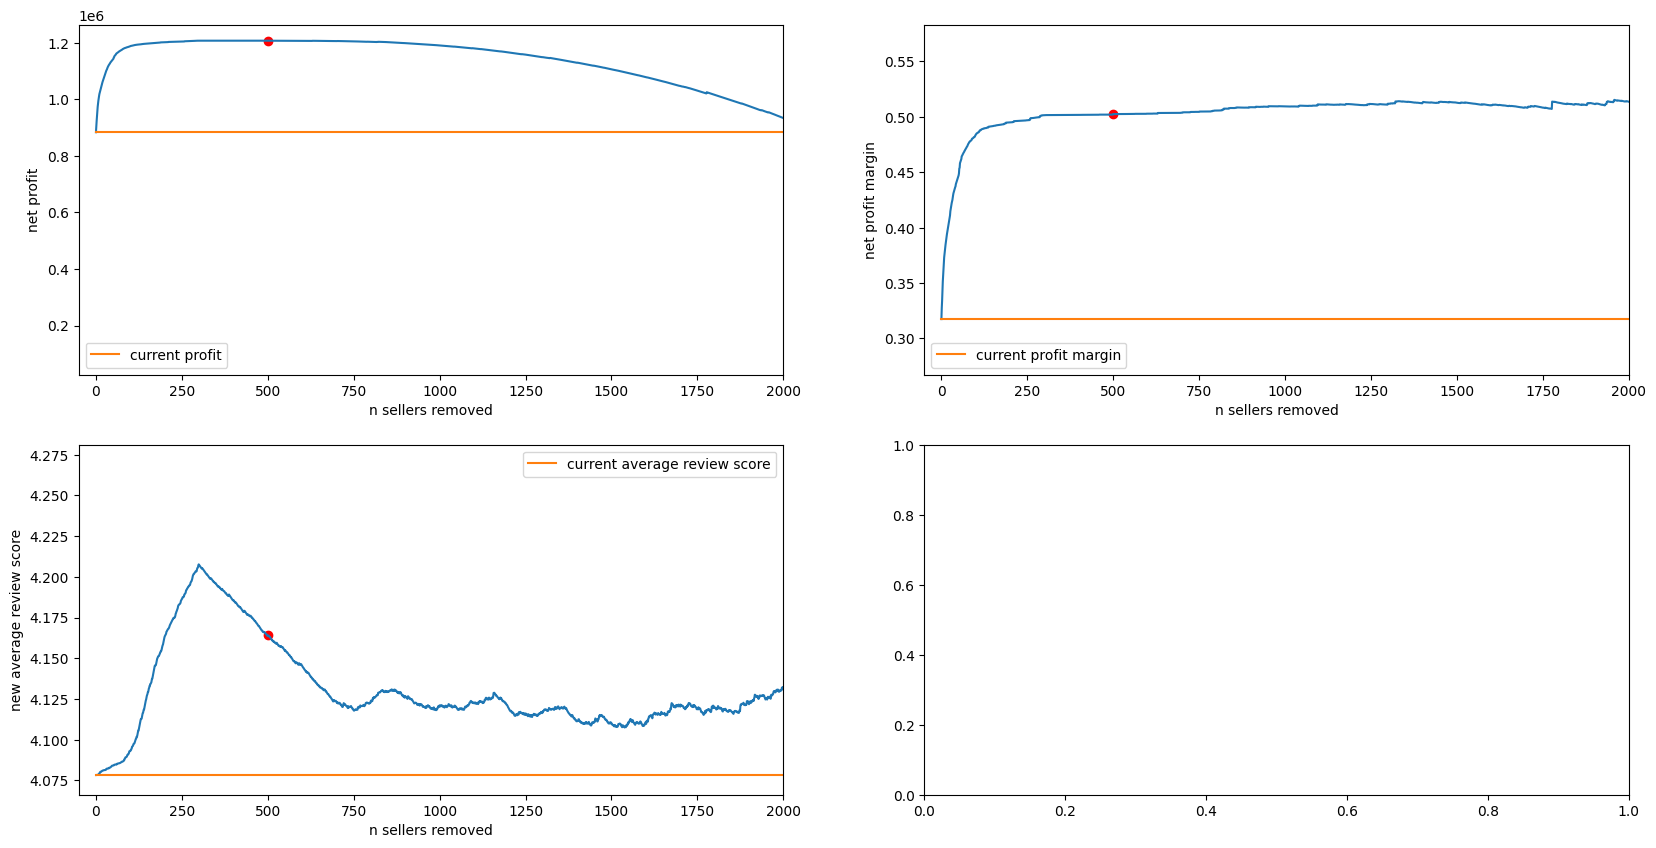

In [297]:
fig, ([ax1, ax2], [ax3, ax4]) = plt.subplots(2, 2, figsize=(20,10))

# plot net profit vs. sellers removed
new_profits.plot(ax=ax1, label='__nolegend__')
ax1.scatter(x1_max, y1_max, color='red')
ax1.plot([0, 2000], [net_profit]*2, label='current profit')
ax1.set_xlabel('n sellers removed')
ax1.set_ylabel('net profit')
ax1.set_xlim([-50,2000])
ax1.legend(loc='lower left')

# plot net profit margin vs. sellers removed
new_profits_margin.plot(ax=ax2, label='__nolegend__')
ax2.scatter(x1_max, new_profits_margin[x1_max], color='red')
ax2.plot([0, 2000], [net_profit_margin]*2, label='current profit margin')
ax2.set_xlabel('n sellers removed')
ax2.set_ylabel('net profit margin')
ax2.set_xlim([-50,2000])
ax2.legend(loc='lower left')

#plot avg review score vs. sellers removed
ax3.plot(orders_removed, new_avg_review)
ax3.scatter(x1_max, new_avg_review[x1_max], color='red')
ax3.plot([0, 2000], [sellers_pl.review_score.mean()]*2, label='current average review score')
ax3.set_xlabel('n sellers removed')
ax3.set_ylabel('new average review score')
ax3.set_xlim([-50,2000])
ax3.legend(loc='upper right')

plt.show()

### Removing sellers by average review score threshold
- remove sellers based on avg review_score up to a threshold
- plot # of sellers removed vs new net profit margin

In [281]:
review_score_threshold = np.arange(1,3.01,.02)
new_profit_margin = []
new_profit = []
n_sellers = []
new_review = []

#loop to calculate new profit margin, number of remaining sellers every time sellers under an avg review score threshold is removed
for i in review_score_threshold:
    x_revenue = sellers_pl[sellers_pl['review_score'] <= i]['olist_revenue'].sum()
    x_profit = sellers_pl[sellers_pl['review_score'] <= i]['olist_profit'].sum()
    new_n_orders = orders.query("order_status == 'delivered'").order_id.count() - sellers_pl[sellers_pl['review_score'] <= i]['n_orders'].sum()
    new_IT = IT_sf * (new_n_orders ** 0.5)
    new_pm = (profit_t - x_profit - new_IT) / (revenue_t - x_revenue)
    new_profit_margin.append(new_pm)
    new_profit.append(profit_t - x_profit - new_IT)
    n_sellers.append(len(sellers_pl) - len(sellers_pl[sellers_pl['review_score'] <= i]))
    new_review.append(sellers_pl[sellers_pl['review_score'] > i]['review_score'].mean())

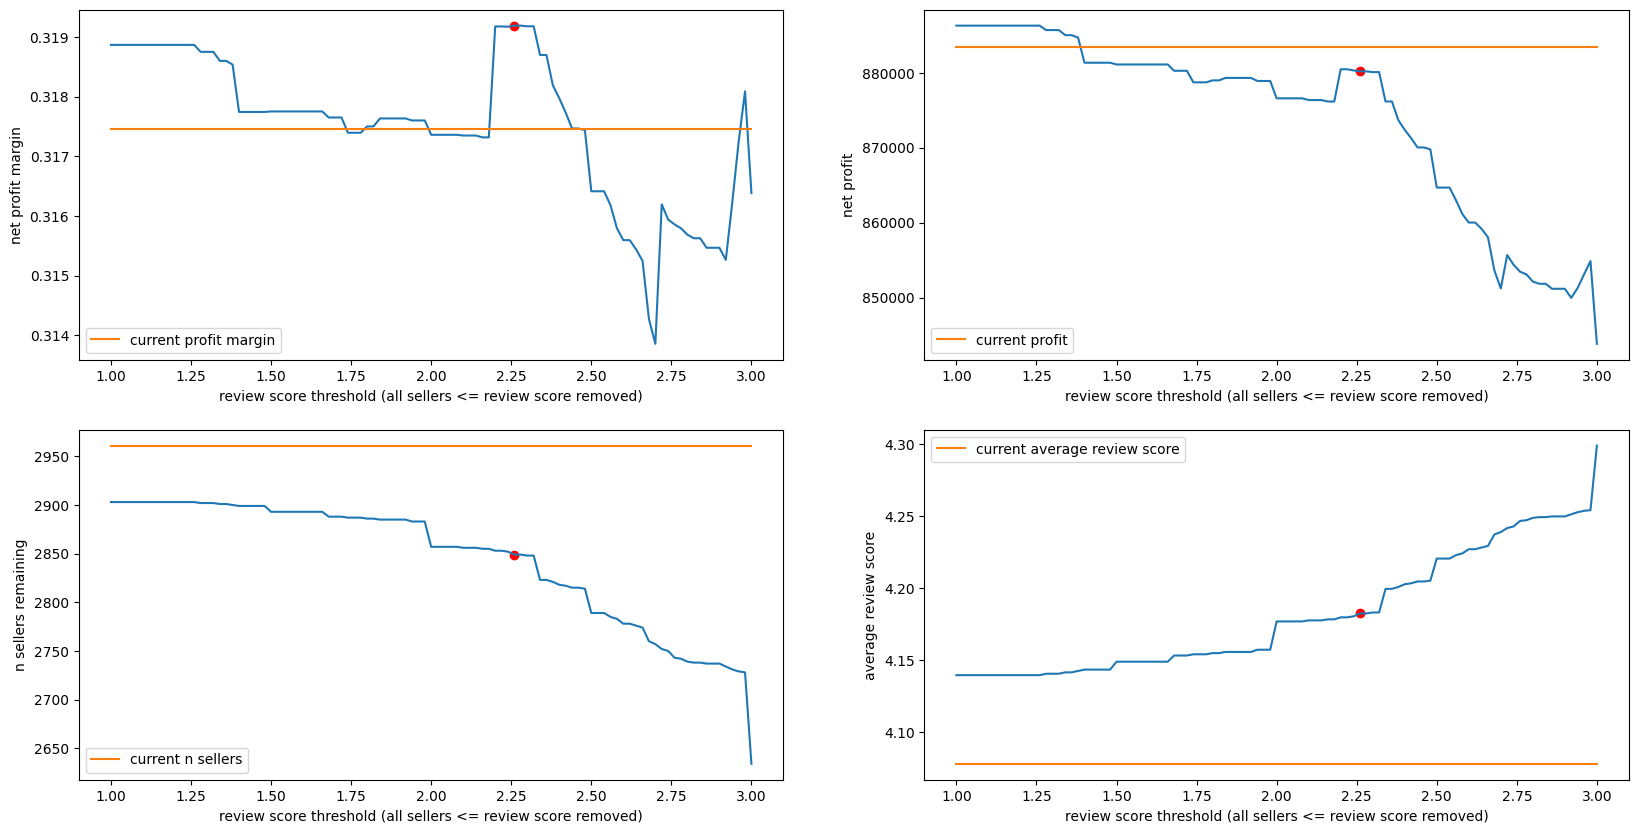

In [291]:
fig, ([ax5, ax6], [ax7, ax8]) = plt.subplots(2, 2, figsize=(20,10))

# plot net profit margin vs. review score threshold
ax5.plot(review_score_threshold, new_profit_margin)
ax5.plot(review_score_threshold, [net_profit / revenue_t]*len(review_score_threshold), label='current profit margin')
ax5.scatter(review_score_threshold[new_profit_margin.index(max(new_profit_margin))], max(new_profit_margin), color='red')
ax5.set_xlabel('review score threshold (all sellers <= review score removed)')
ax5.set_ylabel('net profit margin')
ax5.legend(loc='lower left')

# plot net profit vs. review score threshold
ax6.plot(review_score_threshold, new_profit)
ax6.plot(review_score_threshold, [net_profit]*len(review_score_threshold), label='current profit')
ax6.scatter(review_score_threshold[new_profit_margin.index(max(new_profit_margin))], new_profit[new_profit_margin.index(max(new_profit_margin))], color='red')
ax6.set_xlabel('review score threshold (all sellers <= review score removed)')
ax6.set_ylabel('net profit')
ax6.legend(loc='lower left')

# plot n sellers remaining vs. review score threshold
ax7.plot(review_score_threshold, n_sellers)
ax7.plot(review_score_threshold, [len(sellers_pl)]*len(review_score_threshold), label='current n sellers')
ax7.scatter(review_score_threshold[new_profit_margin.index(max(new_profit_margin))], n_sellers[new_profit_margin.index(max(new_profit_margin))], color='red')
ax7.set_xlabel('review score threshold (all sellers <= review score removed)')
ax7.set_ylabel('n sellers remaining')
ax7.legend(loc='lower left')

# plot new review scores vs. review score threshold
ax8.plot(review_score_threshold, new_review)
ax8.plot(review_score_threshold, [sellers_pl.review_score.mean()]*len(review_score_threshold), label='current average review score')
ax8.scatter(review_score_threshold[new_profit_margin.index(max(new_profit_margin))], new_review[new_profit_margin.index(max(new_profit_margin))], color='red')
ax8.set_xlabel('review score threshold (all sellers <= review score removed)')
ax8.set_ylabel('average review score')
ax8.legend(loc='upper left')

plt.show();